## Makemore pt3

In [1]:
import torch

In [25]:
import torch.nn.functional as F

In [32]:
import matplotlib.pyplot as plt

In [42]:
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build vocab and mappings
chars = sorted(list(set(''.join(words))))
itos = {i+1:c for i,c in enumerate(chars)}
itos[0] = "."
stoi = {c:i for i,c in itos.items()}
vocab_size = len(stoi)
vocab_size

27

In [5]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y
            

In [34]:
# data splits
import random
random.seed(42)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

random.shuffle(words)


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [58]:
# MLP revisited
n_embd = 10 # dimension of the characters embeddings
neurons_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                       generator = g)
W1 = torch.randn((n_embd * block_size, neurons_hidden), generator = g)
b1 = torch.randn(neurons_hidden,                            generator = g)
W2 = torch.randn((neurons_hidden, vocab_size),              generator = g) * 0.01
b2 = torch.randn(vocab_size,                                generator = g) * 0

parameters = [C, W1, b1, W2, b2]

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 11897


In [59]:
# optimization
max_steps = 200000
batch_size = 32
lossi = list()

for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if (i % 10000) == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.299860


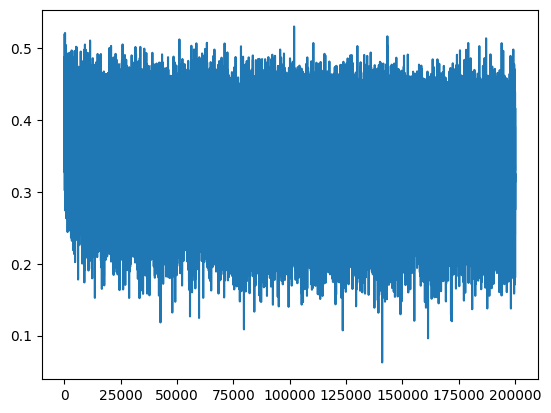

In [57]:
plt.plot(lossi)

In [60]:
h

tensor([[-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000],
        [ 0.1131,  0.2711, -1.0000,  ..., -0.9979,  0.9930,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-0.1424, -0.9988, -0.7355,  ..., -1.0000,  1.0000,  1.0000],
        [-0.9610,  0.7872, -0.9890,  ..., -1.0000,  0.9994,  1.0000],
        [-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)

In [43]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2080860137939453
val 2.2769291400909424


In [51]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10 )

num_names = 21
for _ in range(num_names):
    out = list()
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[context]
        h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()

        # shift context window
        context = context[1:] + [ix]

        # update new character
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahzabelle.
khy.
mish.
tetleenandeller.
hutt.
den.
rhy.
treyi.
ner.
kitt.
madir.
kaleigh.
ham.
pord.
quinton.
lilto.
jadbi.
wayth.
givaryxia.
kaeliigh.
ton.


In [47]:
emb.view(1, -1)

tensor([[ 2.5980,  0.5394,  0.0978, -0.9287,  0.5615,  0.1816, -2.4448,  0.8508,
          0.5875,  1.7962,  2.5980,  0.5394,  0.0978, -0.9287,  0.5615,  0.1816,
         -2.4448,  0.8508,  0.5875,  1.7962,  2.5980,  0.5394,  0.0978, -0.9287,
          0.5615,  0.1816, -2.4448,  0.8508,  0.5875,  1.7962]],
       grad_fn=<ViewBackward0>)

In [50]:
emb.view(emb.shape[0], -1).shape

torch.Size([3, 10])

In [49]:
emb.shape

torch.Size([3, 10])

## Problems with our previous implementation

### Fixing the initial loss
The first item of the loss is too high and then it stabilizes. That causes the loss plot to look like a hockey stick which gauges that the model is learning the bias only in the first iterations. 
- **Cause:** A poor initialization of the last layers wandb
- **Solution:** Scale `W1` by `0.01` and set `b2 = b2 * 0`

### Fixing saturated tanh
- If we see the values of `h` after the first iteration we see this
``` tensor([[-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000],
        [ 0.1131,  0.2711, -1.0000,  ..., -0.9979,  0.9930,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-0.1424, -0.9988, -0.7355,  ..., -1.0000,  1.0000,  1.0000],
        [-0.9610,  0.7872, -0.9890,  ..., -1.0000,  0.9994,  1.0000],
        [-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)
```

- If wee see the values of `h` in a histogram we get this


(array([2180.,  163.,   90.,   79.,   55.,   49.,   36.,   36.,   33.,
          30.,   40.,   33.,   25.,   26.,   17.,   19.,   26.,   29.,
          23.,   21.,   22.,   26.,   20.,   30.,   15.,   16.,   16.,
          17.,   13.,   14.,   27.,   31.,   25.,   24.,   15.,   24.,
          31.,   25.,   27.,   28.,   28.,   46.,   39.,   46.,   63.,
          66.,   71.,  110.,  181., 2294.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

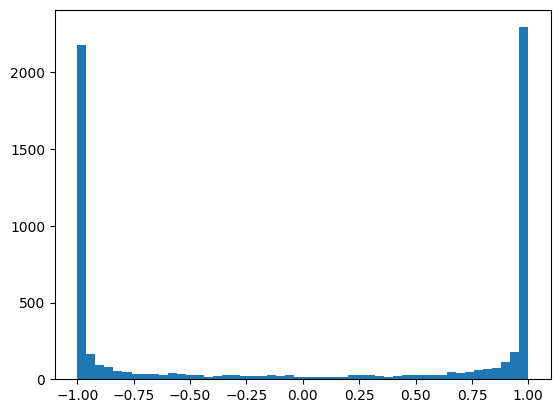

In [66]:
plt.hist(h.view(-1).tolist(), 50)

That histograms tells us that this `tanh` function is very active. We can see why is that seeing the preactivations of `h`

In [72]:
hpreact = emb.view(-1, block_size * n_embd) @ W1 + b1

(array([2180.,  163.,   90.,   79.,   55.,   50.,   35.,   36.,   33.,
          31.,   39.,   33.,   25.,   26.,   17.,   19.,   26.,   29.,
          23.,   21.,   19.,   28.,   23.,   28.,   15.,   16.,   16.,
          17.,   13.,   14.,   27.,   31.,   24.,   25.,   15.,   23.,
          32.,   25.,   27.,   28.,   28.,   46.,   36.,   49.,   63.,
          64.,   73.,  110.,  181., 2294.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

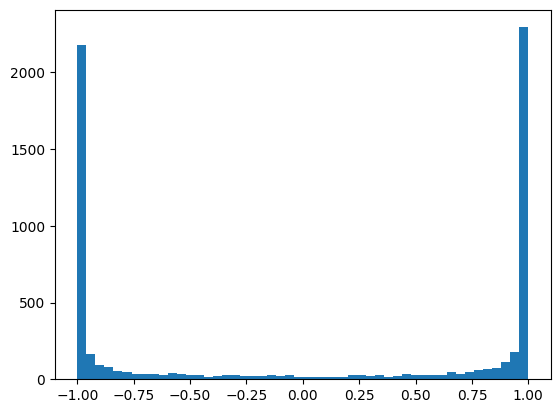

In [73]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [ ]:
# questions
# 1. why is the tanh histogram giving a lot of 1s and -1 when the most frequent preact value is 0? should it be also zero?